<a href="https://www.kaggle.com/code/chihsiangliao/cancer-classification-cnn?scriptVersionId=213459508" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Training samples: 6466
Test samples: 3509
Class distribution - Benign: 3125, Malignant: 6850
Number of classes: 2
Using device: cuda


Epoch 1/10: 100%|██████████| 203/203 [00:56<00:00,  3.60it/s]


Epoch 1, Loss: 0.6649948901730806


Epoch 2/10: 100%|██████████| 203/203 [00:56<00:00,  3.61it/s]


Epoch 2, Loss: 0.5224636219111569


Epoch 3/10: 100%|██████████| 203/203 [00:56<00:00,  3.58it/s]


Epoch 3, Loss: 0.5213248019147976


Epoch 4/10: 100%|██████████| 203/203 [01:28<00:00,  2.28it/s]


Epoch 4, Loss: 0.47512632314794756


Epoch 5/10: 100%|██████████| 203/203 [01:02<00:00,  3.23it/s]


Epoch 5, Loss: 0.45179099417085133


Epoch 6/10: 100%|██████████| 203/203 [00:56<00:00,  3.59it/s]


Epoch 6, Loss: 0.42247932668536753


Epoch 7/10: 100%|██████████| 203/203 [00:56<00:00,  3.58it/s]


Epoch 7, Loss: 0.3981737846685252


Epoch 8/10: 100%|██████████| 203/203 [00:57<00:00,  3.53it/s]


Epoch 8, Loss: 0.37014745484138356


Epoch 9/10: 100%|██████████| 203/203 [00:57<00:00,  3.54it/s]


Epoch 9, Loss: 0.3113307864198764


Epoch 10/10: 100%|██████████| 203/203 [01:03<00:00,  3.21it/s]



Epoch 10, Loss: 0.304165428274958
              precision    recall  f1-score   support

      Benign       0.81      0.87      0.84      1160
   Malignant       0.93      0.90      0.92      2349

    accuracy                           0.89      3509
   macro avg       0.87      0.89      0.88      3509
weighted avg       0.89      0.89      0.89      3509

              precision    recall  f1-score   support

      Benign       0.81      0.87      0.84      1160
   Malignant       0.93      0.90      0.92      2349

    accuracy                           0.89      3509
   macro avg       0.87      0.89      0.88      3509
weighted avg       0.89      0.89      0.89      3509



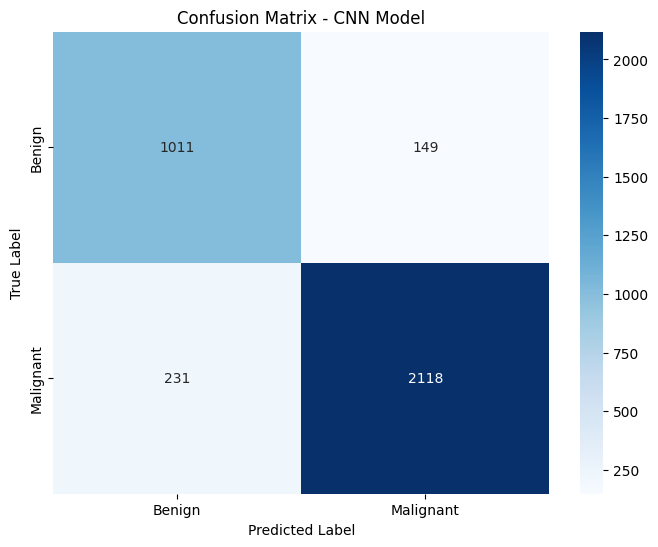

=== CNN 模型詳細效能指標 ===
整體準確率: 0.8917 (89.17%)

良性腫瘤:
精確率: 0.8140 (81.40%)
召回率: 0.8716 (87.16%)
F1-score: 0.8418

惡性腫瘤:
精確率: 0.9343 (93.43%)
召回率: 0.9017 (90.17%)
F1-score: 0.9177

=== 醫療意義分析 ===
假陰性(漏診惡性): 231 例 (9.83%)
假陽性(誤診良性為惡性): 149 例 (12.84%)
真陽性(正確診斷惡性): 2118 例
真陰性(正確診斷良性): 1011 例


In [2]:
import cv2
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import os
#import CNN model
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from tqdm import tqdm
# Load data
file_path = r'C:\Users\user\Desktop\folder\cancer-classification-main\Folds.csv'
data = pd.read_csv(file_path)

# derive 'label' from the 'filename' column
data['label'] = data['filename'].apply(lambda x: 0 if 'benign' in x else 1)
# filter data for magnification(mag) == 40
data = data[data['mag'] == 40]

#prepare dataset
#parameters
target_size = (224, 224) #target size for CNN input
# Define the base path for images - data is in archive/BreaKHis_v1 folder (nested structure)
base_image_path = r'C:\Users\user\Desktop\folder\cancer-classification-main\archive\BreaKHis_v1'

#Dataset class for train and test
class BreastCancerDataset(Dataset):
    def __init__(self, dataframe, target_size, base_path):
        self.dataframe = dataframe
        self.target_size = target_size
        self.base_path = base_path

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        relative_img_path = row['filename']
        # Construct the full image path and normalize path separators
        img_path = os.path.join(self.base_path, relative_img_path)
        img_path = os.path.normpath(img_path)  # Convert forward slashes to backslashes on Windows
        label = row['label']
    
        #load image
        img = cv2.imread(img_path)
        if img is None:
            # Try to find the image with a debug print
            print(f"Debug: Looking for image at: {img_path}")
            print(f"Debug: File exists: {os.path.exists(img_path)}")
            if os.path.exists(os.path.dirname(img_path)):
                print(f"Debug: Directory exists, files in directory: {os.listdir(os.path.dirname(img_path))[:5]}")
            raise FileNotFoundError(f"Image not found: {img_path}")
        
        #Resize and preprocess
        img = cv2.resize(img, self.target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to RGB
        img = img / 255.0 # Normalize to [0, 1]
        img = np.transpose(img, (2, 0, 1)) # Convert to (C, H, W)

        #convert to tensor
        img_tensor = torch.tensor(img, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return img_tensor, label_tensor
    
# Split data into train and test based on 'grp'
train_df = data[data['grp'] == 'train']
test_df = data[data['grp'] == 'test']

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Class distribution - Benign: {sum(data['label'] == 0)}, Malignant: {sum(data['label'] == 1)}")

# Create train and test datasets
train_dataset = BreastCancerDataset(train_df, target_size, base_image_path)
test_dataset = BreastCancerDataset(test_df, target_size, base_image_path)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Define CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64* 56 * 56, 128) # Adjust according to input size
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) # Flatten the feature map
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
# Initialize the model, loss function, and optimizer
num_classes = 2  # Binary classification: benign (0) vs malignant (1)
print(f'Number of classes: {num_classes}')
model = CNNModel(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
model.to(device)

#Training function
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            #zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

epochs = 10
train_model(model, train_loader, criterion, optimizer, epochs)


# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Evaluate the model
y_test, y_pred = evaluate_model(model, test_loader)

target_names = ['Benign', 'Malignant'] # define label name (fixed typo)
print(classification_report(y_test, y_pred, target_names=target_names))

# Additional analysis and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - CNN Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision_benign = precision_score(y_test, y_pred, pos_label=0)
precision_malignant = precision_score(y_test, y_pred, pos_label=1)
recall_benign = recall_score(y_test, y_pred, pos_label=0)
recall_malignant = recall_score(y_test, y_pred, pos_label=1)
f1_benign = f1_score(y_test, y_pred, pos_label=0)
f1_malignant = f1_score(y_test, y_pred, pos_label=1)

print("=== CNN 模型詳細效能指標 ===")
print(f"整體準確率: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\n良性腫瘤:")
print(f"精確率: {precision_benign:.4f} ({precision_benign*100:.2f}%)")
print(f"召回率: {recall_benign:.4f} ({recall_benign*100:.2f}%)")
print(f"F1-score: {f1_benign:.4f}")
print(f"\n惡性腫瘤:")
print(f"精確率: {precision_malignant:.4f} ({precision_malignant*100:.2f}%)")
print(f"召回率: {recall_malignant:.4f} ({recall_malignant*100:.2f}%)")
print(f"F1-score: {f1_malignant:.4f}")

# Medical significance
print(f"\n=== 醫療意義分析 ===")
print(f"假陰性(漏診惡性): {cm[1,0]} 例 ({cm[1,0]/np.sum(cm[1,:])*100:.2f}%)")
print(f"假陽性(誤診良性為惡性): {cm[0,1]} 例 ({cm[0,1]/np.sum(cm[0,:])*100:.2f}%)")
print(f"真陽性(正確診斷惡性): {cm[1,1]} 例")
print(f"真陰性(正確診斷良性): {cm[0,0]} 例")